In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
from kloppy import secondspectrum


In [3]:
import sys
 
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz

In [4]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=True)


In [5]:
home_df, away_df = get_home_away_tracking(dataset)

In [6]:
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [8]:
params=pc.parameters()

In [61]:
df = dataset.to_df()

In [89]:
frame = 73413
attacking_team = df.loc[df.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Home'

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

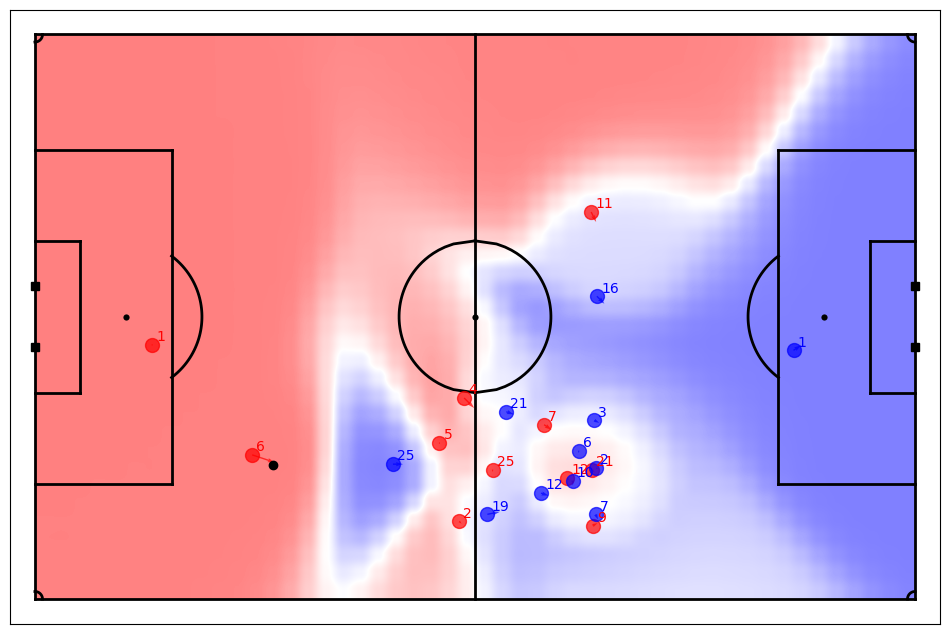

In [92]:
viz.plot_pitch_control_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

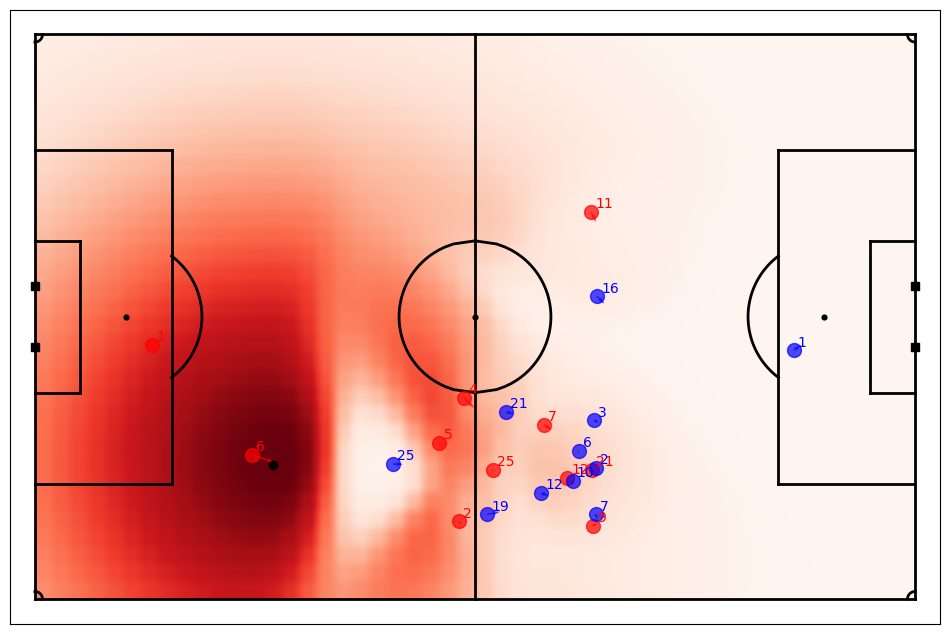

In [94]:
viz.plot_transition_proba_for_frame(frame, tracking_home, tracking_away, attacking_team,params)

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

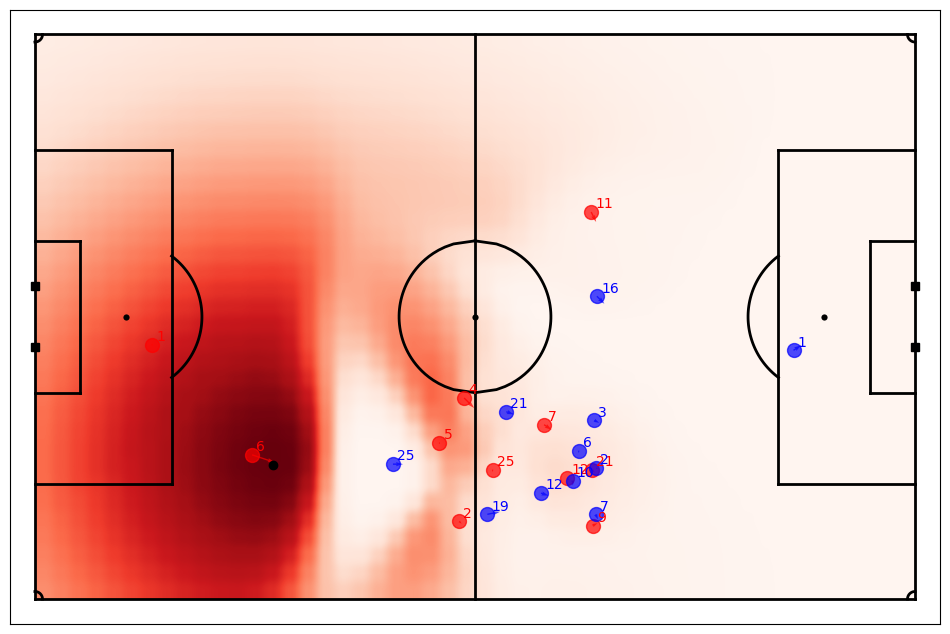

In [95]:
viz.plot_relevant_pitch_for_frame(frame, tracking_home, tracking_away, attacking_team ,params)

In [9]:
import socceraction.xthreat as xthreat
# Load the xT model in

def generate_expected_threat_surface(where_attack, field_dimen=(106.,68.), n_grid_cells_x = 100):
    
    url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT_model = xthreat.load_model(url_grid)
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    interp = xT_model.interpolator()
    xgrid = np.linspace(0, 105, n_grid_cells_x)
    ygrid = np.linspace(0, 68, n_grid_cells_y)
    
    # initialise expected threat 
    xT = interp(xgrid,ygrid)
    if(where_attack == -1):
        xT = xT[:, ::-1]
    return(xT, xgrid, ygrid)

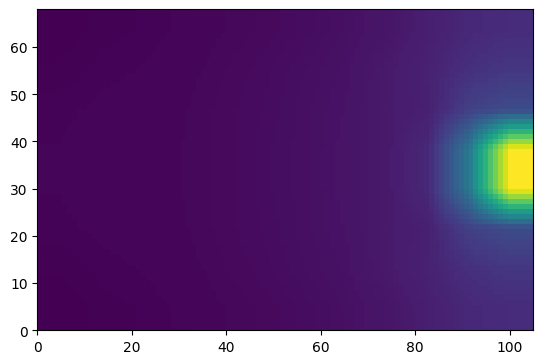

In [10]:
xT, xgrid, ygrid =  generate_expected_threat_surface(1)
xmin = np.amin(xgrid)
xmax = np.amax(xgrid)
plt.imshow(np.flipud(xT), extent=(xmin, xmax, np.amin(ygrid), np.amax(ygrid)),alpha=1)

In [11]:
def generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    where_home_attacks = pc.where_home_team_attacks(tracking_home)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
    
    xG, xgrid, ygrid = generate_expected_threat_surface(where_attack, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    rel_PPCF,xgrid,ygrid = viz.generate_relevant_pitch_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    return(xG*rel_PPCF,xgrid,ygrid)

In [12]:
def plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    #find attacking team    
    # plot frame and event
    fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
    viz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    

    # plot pitch control surface
    if attacking_team=='Home':
        cmap = 'Reds'
    else:
        cmap = 'Blues'

    ax.imshow(np.flipud(off_scoring), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(off_scoring),cmap=cmap)
    
    print('off ball expected threat: '+str(round(np.sum(off_scoring)*100,1))+ "%")
    
    return(fig,ax)
    

off ball expected threat: 0.9%


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

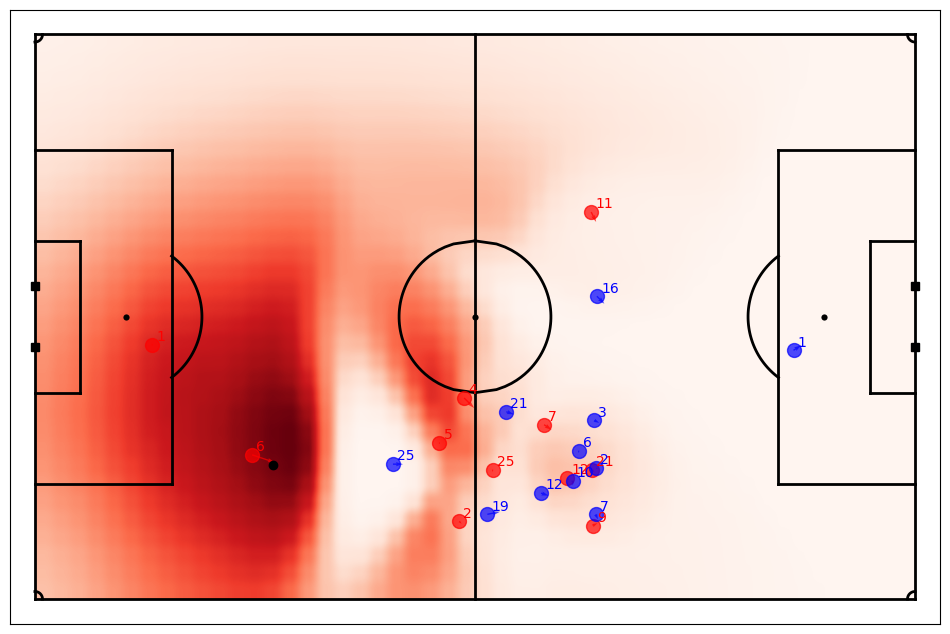

In [100]:
plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

In [ ]:
off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params)
str(round(np.sum(off_scoring)*100,1))

'1.4'

In [13]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/375,
    coordinates="secondspectrum",
    only_alive=True)

In [14]:
x = dataset.to_df()

In [15]:
frames = []
team = []
value = []
time = []
period = []
for index, row in x.iterrows():
    print(index)
    attacking_team = row["ball_owning_team_id"].capitalize()
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(row["frame_id"], tracking_home, tracking_away, attacking_team, params)
    frames.append(row["frame_id"])
    period.append(row["period_id"])
    team.append(attacking_team)
    value.append(round(np.sum(off_scoring)*100,1))
    time.append(row['timestamp'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


In [36]:
value_df = pd.DataFrame(
    {'frame': frames,
     'team': team,
     'time': time,
     'value': value,
     'period': period
    })

In [37]:
value_df.shape

(229, 5)

In [38]:
value_df.columns

Index(['frame', 'team', 'time', 'value', 'period'], dtype='object')

In [39]:
value_df['xT'] = value_df['value'] * value_df['team'].apply(lambda x: 1 if x == 'Home' else -1)

In [40]:
for i in value_df.index:
    if i > 119:
        value_df.loc[i, 'time'] += 2700

In [41]:
value_df.head()

,frame,team,time,value,period,xT
0,1,Home,0.04,1.1,1,1.1
1,376,Home,15.04,0.8,1,0.8
2,751,Home,30.04,0.7,1,0.7
3,1126,Away,45.04,1.3,1,-1.3
4,1501,Home,60.04,0.8,1,0.8


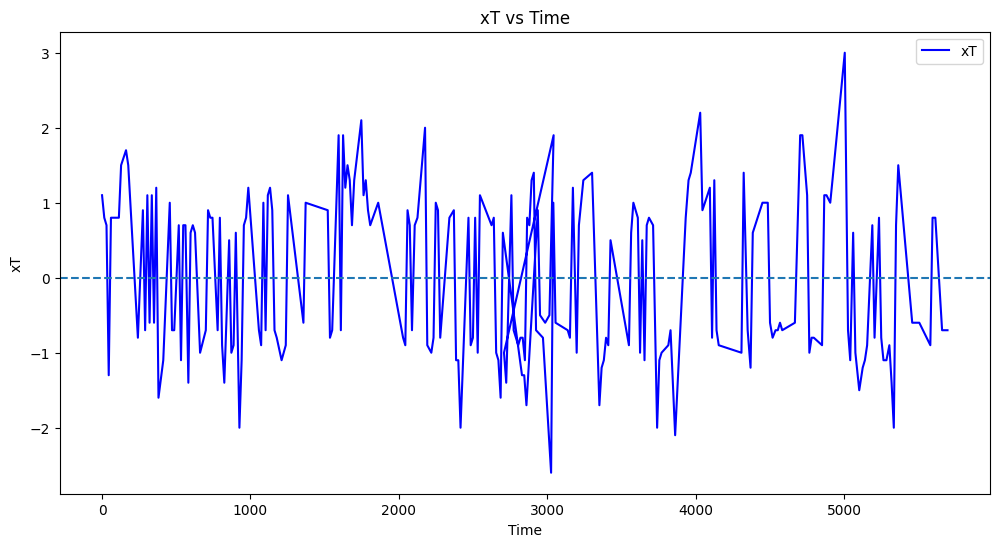

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create line chart with blue and red colors
value_df.plot(x='time', y='xT', kind='line', color='b', ax=ax)

# Add labels to the chart
plt.xlabel('Time')
plt.ylabel('xT')

# Add x-axis line at xT=0
ax.axhline(y=0, linestyle='--')

plt.title('xT vs Time')
plt.show()

In [60]:
frame = 60394
attacking_team = x.loc[x.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Away'

off ball expected threat: 2.0%


(<Figure size 1200x800 with 1 Axes>, <Axes: >)

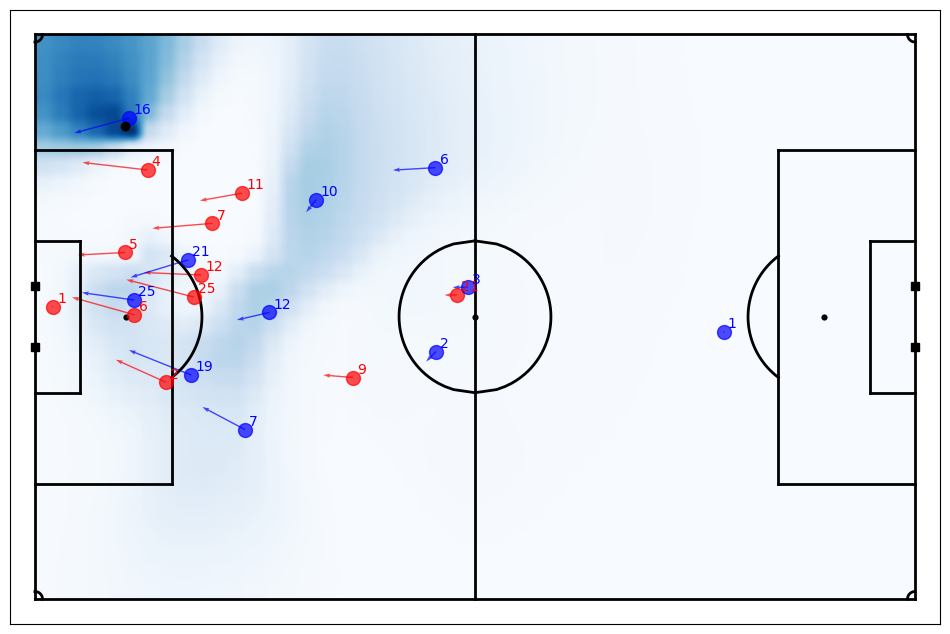

In [61]:
plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)